<a href="https://colab.research.google.com/github/gitanjalisalunke/deepfake-detection/blob/main/final_model_image_forgery_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from tensorflow.keras.utils import Sequence
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau #Import callback functions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau #Import callback functions

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data = r'/content/drive/MyDrive/dataset/train'

In [ ]:
batch_size = 32 #Number of images processed at a time.
img_height = 224  #Resizes images to 224x224 pixels (needed for MobileNet).
img_width = 224

In [ ]:
data

'/content/drive/MyDrive/dataset/train'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
'''train_datagen:
zoom_range=0.15: Randomly zooms into images by 15%.
width_shift_range=0.2: Shifts images horizontally by 20%.
shear_range=0.15: Applies shear transformation to images.'''

train_datagen = ImageDataGenerator(zoom_range=0.15, width_shift_range=0.2, shear_range=0.15)
test_datagen = ImageDataGenerator()

#Setting train/test split
#Loads training and testing images from the dataset.

train = train_datagen.flow_from_directory(data, target_size=(img_height, img_width),
class_mode="categorical", batch_size=batch_size, subset="training")

test =test_datagen.flow_from_directory(data, target_size=(img_height, img_width),
class_mode="categorical", batch_size=batch_size, shuffle=False)


Found 252 images belonging to 2 classes.
Found 252 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Number of images processed at a time.
batch_size = 32
#Resizes images to 224x224 pixels (needed for MobileNet).
img_height = 224
img_width = 224

'''train_datagen:
zoom_range=0.15: Randomly zooms into images by 15%.
width_shift_range=0.2: Shifts images horizontally by 20%.
shear_range=0.15: Applies shear transformation to images.'''

train_datagen = ImageDataGenerator(zoom_range=0.15, width_shift_range=0.2, shear_range=0.15)
test_datagen = ImageDataGenerator()

#Setting train/test split
#Loads training and testing images from the dataset.

train = train_datagen.flow_from_directory(data, target_size=(img_height, img_width),
class_mode="categorical", batch_size=batch_size, subset="training")

test =test_datagen.flow_from_directory(data, target_size=(img_height, img_width),
class_mode="categorical", batch_size=batch_size, shuffle=False)


Found 252 images belonging to 2 classes.
Found 252 images belonging to 2 classes.


In [ ]:
#how much classes there are
classess = train.num_classes
classess

2

In [ ]:
#Uses MobileNet, a lightweight CNN trained on ImageNet, as a feature extractor.
Mobilenet = MobileNet(weights='imagenet', include_top = False, input_shape = (224,224,3))

In [ ]:
#Freezes all layers of MobileNet (prevents modification during training)
for i in Mobilenet.layers:
    i.trainable = False # Indented this line by 4 spaces

In [ ]:
'''Builds a fully connected neural network on top of MobileNet.
GlobalAveragePooling2D(): Reduces dimensions before passing to dense layers.
Dense(1024, activation='relu'): Adds fully connected layers with ReLU activation.
Dense(classes, activation='softmax'): Classifies images into respective categories.'''

def main_model(tl_model, classess):
    m_model = tl_model.output
    m_model = GlobalAveragePooling2D()(m_model) # Corrected typo: GlobalAveragePooling2D
    m_model = Dense(1024, activation='relu')(m_model)
    m_model = Dense(1024, activation='relu')(m_model)
    m_model = Dense(512, activation='relu')(m_model) # Fixed missing comma
    m_model = Dense(classess, activation='softmax')(m_model)
    return m_model

In [ ]:
#Combines MobileNet and the custom model into a complete network.
combining_model = main_model # Assuming main_model is defined elsewhere
# or
# combining_model = main_model(Mobilenet, classess) # if main_model is a function

In [ ]:
# Call the main_model function with the base model and number of classes
combining_model = main_model(Mobilenet, classess)

# Create the Model instance with the correct 'outputs' keyword argument
model = Model(inputs=Mobilenet.input, outputs=combining_model)

In [ ]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,853,890 (22.33 MB)

 Trainable params: 2,625,026 (10.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
#Monitor the performance. If it dips, then stop training
learning_rate_reduce=ReduceLROnPlateau(monitor="val_accuracy", min_lr=0.001)
#Change learning rate if not performing good enough
callbacks = [earlystop, learning_rate_reduce]
#Change learning rate if not performing good enough
callbacks = [earlystop, learning_rate_reduce]

In [ ]:
# Instead of:
# from tensorflow.keras.models import Functional

# Use this import:
from tensorflow import keras

# Access the Functional class using:
keras.Model

# Modify your code to replace Functional with keras.Model:

def wit(self, train, validation_data, epochs):
    """
    Custom function to train the model.
    For demonstration, it simply calls the existing `fit` method.
    """
    return self.fit(train, validation_data=validation_data, epochs=epochs)

# Monkey patch the 'wit' method to the keras.Model class
keras.Model.wit = wit

# Now you can use 'wit' on your model:
history = model.wit(train, validation_data=test, epochs=5)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 8s/step - accuracy: 0.4702 - loss: 1.9818 - val_accuracy: 0.5000 - val_loss: 0.7287
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.5063 - loss: 0.7318 - val_accuracy: 0.7103 - val_loss: 0.6355
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.6279 - loss: 0.6516 - val_accuracy: 0.5952 - val_loss: 0.6317
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.5964 - loss: 0.6417 - val_accuracy: 0.7738 - val_loss: 0.5214
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.7672 - loss: 0.5364 - val_accuracy: 0.8095 - val_loss: 0.4333


In [ ]:
model.save("my_model.keras")

In [ ]:
test_score = model.evaluate(test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8198 - loss: 0.4410


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

target_names = []
for key in train.class_indices:
    target_names.append(key)  # Indented by 4 spaces
target_names = []
for key in train.class_indices:
    target_names.append(key)  # Indented by 4 spaces

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize True.
    """
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize True.
    """
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes)) # Moved this line inside the function
    plt.xticks(tick_marks, classes, rotation=45) # Moved this line inside the function
    plt.yticks(tick_marks, classes) # Moved this line inside the function

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# ... (Your code to generate the confusion matrix and call plot_confusion_matrix)

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
Confusion Matrix
Confusion matrix, without normalization
Confusion matrix, without normalization


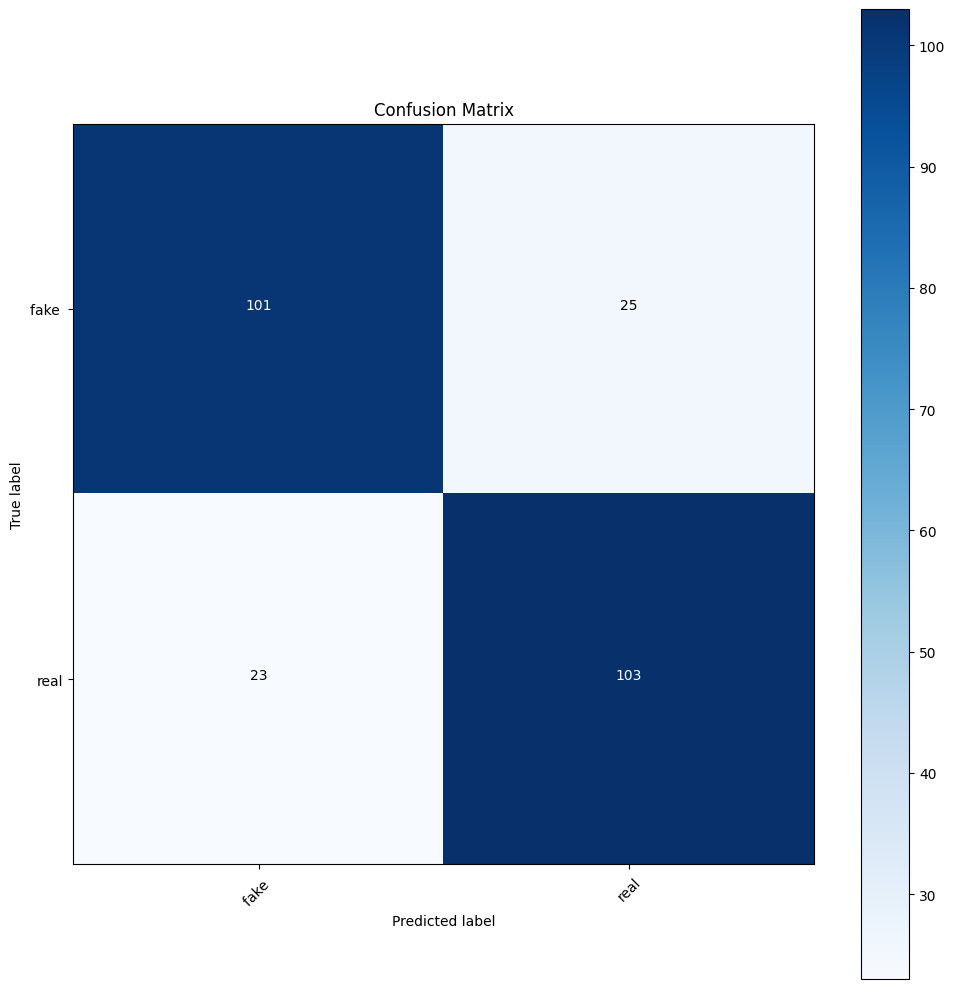

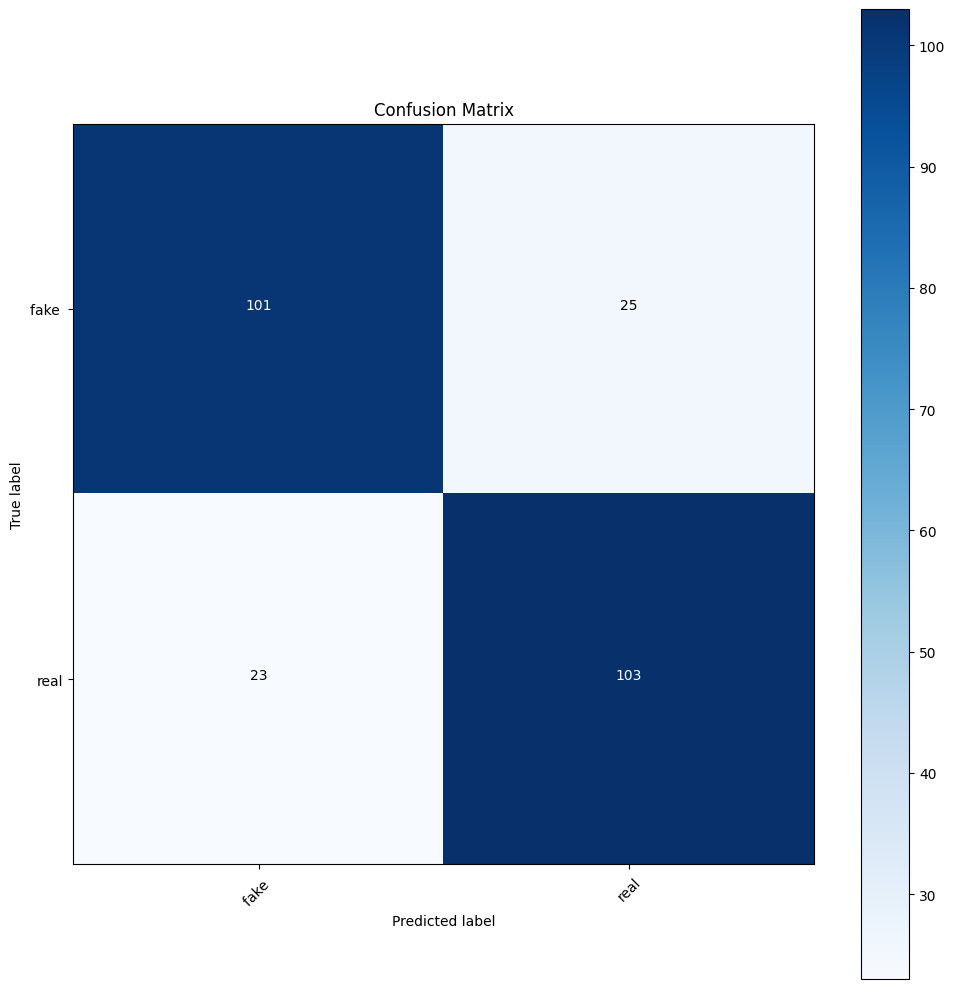

In [ ]:
#Confution Matrix and Classificatiorded with
Y_pred = model.predict(test)
y_pred = np.argmax(Y_pred, axis=-1)
print('Confusion Matrix')
cm=confusion_matrix(test.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
cm=confusion_matrix(test.classes, y_pred)

# Corrected the variable name from target_namex to target_names
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [ ]:
print('Classification Report')
print(classification_report(test.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       fake        0.81      0.80      0.81       126
        real       0.80      0.82      0.81       126

    accuracy                           0.81       252
   macro avg       0.81      0.81      0.81       252
weighted avg       0.81      0.81      0.81       252



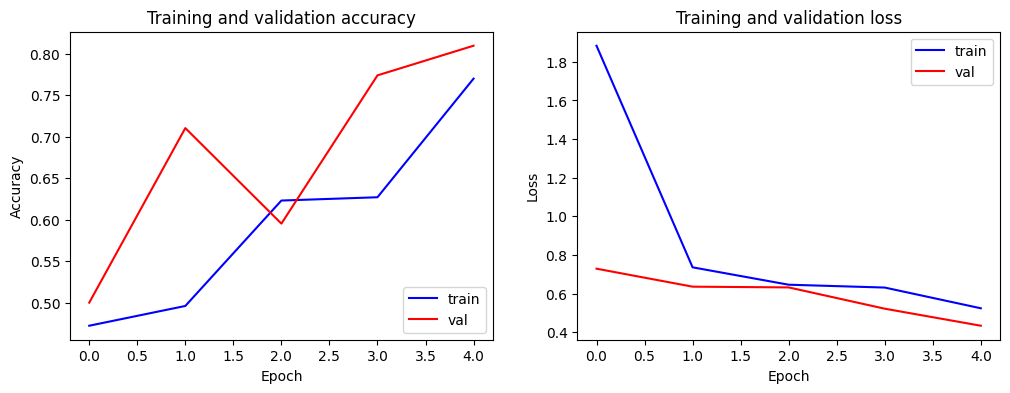

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

#Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

#Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']


plt.show()

In [ ]:
labels = train.class_indices
final_labels = {v: k for k, v in labels.items()}
final_labels

{0: 'fake ', 1: 'real'}

In [ ]:
from tensorflow.keras.models import load_model
import ast
from tensorflow.keras.preprocessing import image

In [ ]:
def predict_image(imgname, from_test_dir):
    test_image = image.load_img(imgname, target_size = (224, 224))

    plt.imshow(test_image)
    plt.show()

    test_image = np.asarray(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    result = model.predict(test_image)


    result_dict= dict()
    for key in list(final_labels.keys()):
        result_dict[final_labels[key]] = result[0][key]
    sorted_results = {k: v for k, v in sorted(result_dict.items(), key=lambda item: item[1], reverse=True)}


    if not from_test_dir:
        print('=' * 50)
        for label in sorted_results.keys():
            print("{}: {}%".format(label, sorted_results[label] * 100))

    final_result = dict()
    final_result[list(sorted_results.keys())[0]] = sorted_results[list(sorted_results.keys())[0]] * 100

    return final_result

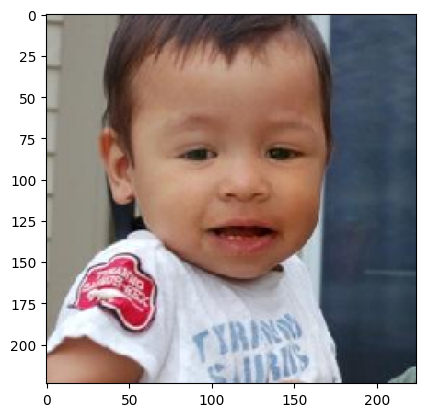

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
fake : 81.18385076522827%
real: 18.81614923477173%
Final Result:  {'fake ': 81.18385076522827}


In [ ]:
#print('=' 50)
final_result1 = predict_image(r'/content/drive/MyDrive/dataset/vallidation/fake/fake_0.jpg', False)

print("Final Result: ", final_result1)

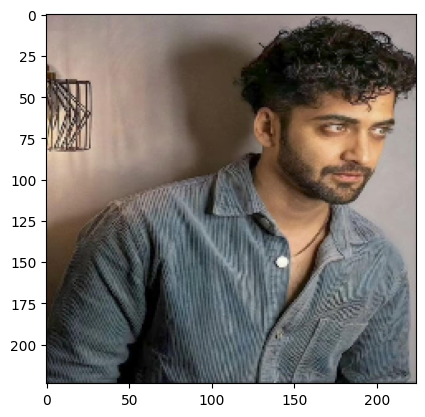

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
real: 70.66991925239563%
fake : 29.33007776737213%
Final Result:  {'real': 70.66991925239563}


In [ ]:
final_result2 = predict_image(r'/content/drive/MyDrive/test/sumedh.jpg', False)
print("Final Result: ", final_result2)

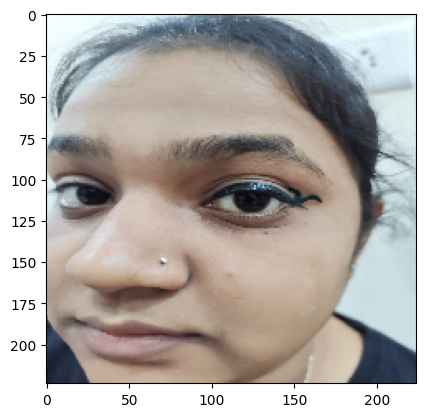

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
fake : 92.19929575920105%
real: 7.800702005624771%
Final Result:  {'fake ': 92.19929575920105}


In [ ]:
final_result2 = predict_image(r'/content/drive/MyDrive/test/us.jpg', False)
print("Final Result: ", final_result2)

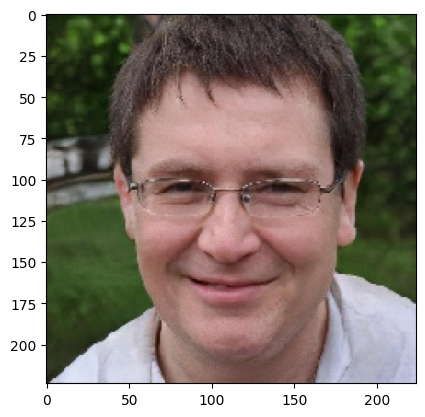

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
fake : 77.37630605697632%
real: 22.62369990348816%
Final Result:  {'fake ': 77.37630605697632}


In [ ]:
final_result2 = predict_image(r'/content/drive/MyDrive/Final Dataset/Fake /002PMM0QG9.jpg', False)
print("Final Result: ", final_result2)

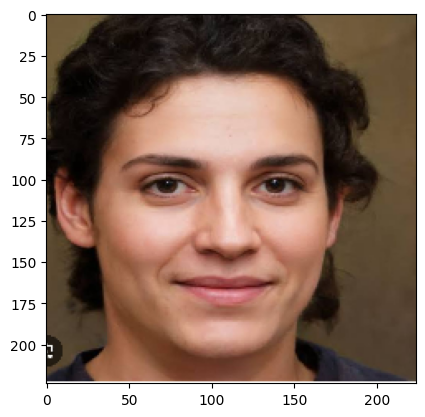

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
fake : 93.75168085098267%
real: 6.248322129249573%
Final Result:  {'fake ': 93.75168085098267}


In [ ]:
final_result2 = predict_image(r'/content/drive/MyDrive/test/79889+566666666666666666666666666666666666666666666666666666666666666666666666666.jpg', False)
print("Final Result: ", final_result2)

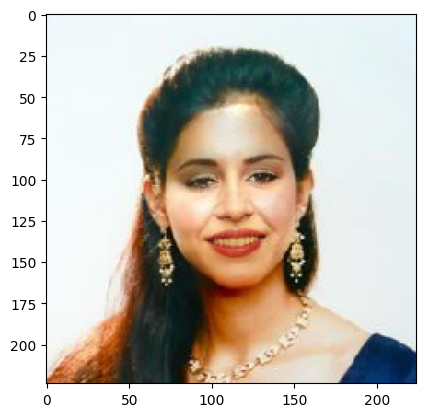

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
fake : 56.01248741149902%
real: 43.987518548965454%
Final Result:  {'fake ': 56.01248741149902}


In [ ]:
final_result2 = predict_image(r'/content/drive/MyDrive/dataset/vallidation/fake/fake_100.jpg', False)
print("Final Result: ", final_result2)

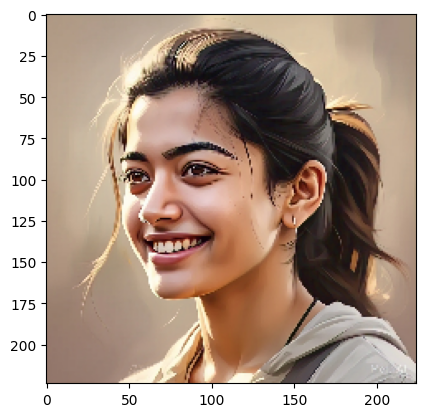

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
fake : 67.08289384841919%
real: 32.91710615158081%
Final Result:  {'fake ': 67.08289384841919}


In [ ]:
final_result2 = predict_image(r'/content/rashmika.jpg', False)
print("Final Result: ", final_result2)

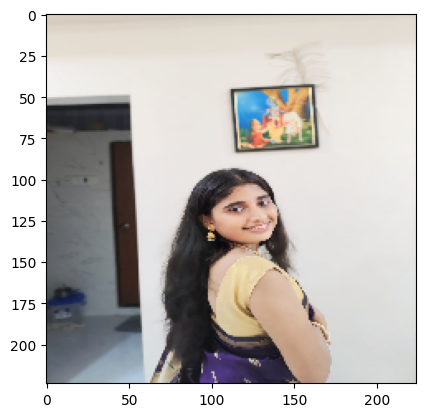

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
fake : 66.02414846420288%
real: 33.97584855556488%
Final Result:  {'fake ': 66.02414846420288}


In [ ]:
final_result2 = predict_image(r'/content/edited me.jpg', False)
print("Final Result: ", final_result2)

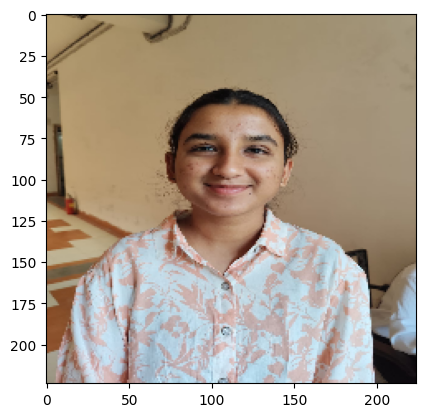

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
real: 71.41717672348022%
fake : 28.582826256752014%
Final Result:  {'real': 71.41717672348022}


In [ ]:
final_result2 = predict_image(r'/content/gaytri.jpg', False)
print("Final Result: ", final_result2)

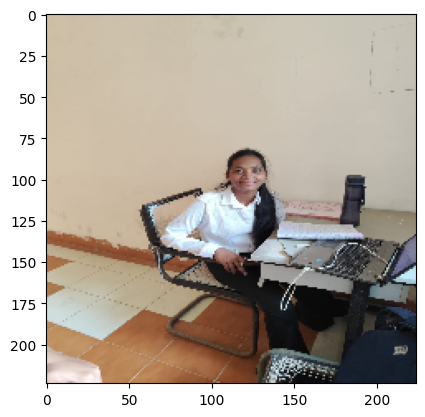

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
real: 67.12042093276978%
fake : 32.8795850276947%
Final Result:  {'real': 67.12042093276978}


In [ ]:
final_result2 = predict_image(r'/content/sy=ujata.jpg', False)
print("Final Result: ", final_result2)